***VANILLA RNN - Manual Python Code***

Step 1: Prepare Data -> Convert Text to Vectors

In [171]:
import numpy as np

text = "hello world"
chars = sorted(list(set(text))) #necessary for building lookup table
vocab_size = len(chars)
print (chars) #shows single char

[' ', 'd', 'e', 'h', 'l', 'o', 'r', 'w']


In [172]:
# Create lookup tables
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}
#This creates a dictionary (mapping character → number)
print (idx_to_char)

{0: ' ', 1: 'd', 2: 'e', 3: 'h', 4: 'l', 5: 'o', 6: 'r', 7: 'w'}


In [173]:
print("Characters:", chars)
print("Vocabulary size:", vocab_size)


Characters: [' ', 'd', 'e', 'h', 'l', 'o', 'r', 'w']
Vocabulary size: 8


In [174]:
# Encode input and target sequences
X = [char_to_idx[ch] for ch in text[:-1]]  # all except last char
Y = [char_to_idx[ch] for ch in text[1:]]   # all except first char

We want the RNN to learn how to predict the next character in a sequence.
So we give it input characters one by one  and we teach it what the next character should be.

text[:-1]

This means “take all characters except the last one”.

For "hello world", that becomes:
['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l']
Because the last character 'd' has no next character to predict , so it’s excluded from the input.

text[1:]

This means “take all characters except the first one”.

For "hello world", that becomes:
['e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd']


In [175]:
print("\nInput indices:", X)
print("Target indices:", Y)


Input indices: [3, 2, 4, 4, 5, 0, 7, 5, 6, 4]
Target indices: [2, 4, 4, 5, 0, 7, 5, 6, 4, 1]


So before training, we must represent each character as a vector of numbers , that’s called one hot encoding.

There are 8 unique characters, so every character gets a vector of length 8.

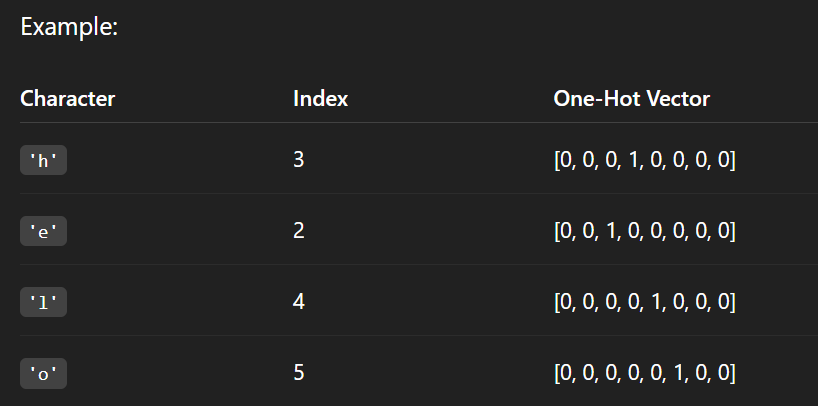

In [176]:
# One-hot encode
def one_hot_encode(idx, size):
    vec = np.zeros((size, 1)) # make a column of zeros (size = vocab size)
    vec[idx] = 1 # set 1 at the position of that character
    return vec
one_hot_encode(3, 8) #That’s the one-hot vector for the 4th character in the vocabulary (index 3 → “h”).


array([[0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.]])

One-hot encoding tells the model “what” the token is.
Positional encoding tells the model “where” the token is.

Step 2: Initialize Parameters

To define all the weights and biases that control
how the RNN processes inputs, remembers information,
and produces outputs at every time step.

These parameters are the learnable parts of the RNN
they get updated during training through backpropagation.

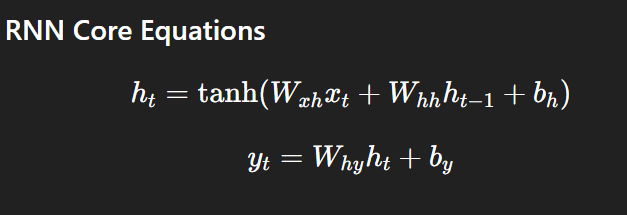



| Symbol   | Name                    | Shape                       | Role / Meaning                                              |
| :------- | :---------------------- | :-------------------------- | :---------------------------------------------------------- |
| (x_t)    | Input at time t         | (vocab_size × 1)            | One-hot vector of the current word or character             |
| (h_t)    | Hidden state            | (hidden_size × 1)           | Model’s internal memory at time t                           |
| (y_t)    | Output vector           | (vocab_size × 1)            | Predicted next character’s probabilities                    |
| (W_{xh}) | Input → Hidden weights  | (hidden_size × vocab_size)  | Connects current input to hidden layer                      |
| (W_{hh}) | Hidden → Hidden weights | (hidden_size × hidden_size) | Connects previous hidden state to current one (memory link) |
| (W_{hy}) | Hidden → Output weights | (vocab_size × hidden_size)  | Converts hidden state into output predictions               |
| (b_h)    | Hidden bias             | (hidden_size × 1)           | Helps neurons activate even when input is small             |
| (b_y)    | Output bias             | (vocab_size × 1)            | Adjusts the output layer’s final prediction                 |


The line **`hidden_size = 16`** in a Recurrent Neural Network (RNN) dictates the **dimensionality of the hidden state** ($h_t$), setting the size of the network's internal **memory** to a vector of 16 numbers ($h_t \in \mathbb{R}^{16}$). These 16 components act as "memory neurons," with each one learning and storing a distinct piece of **context** or a relationship (like grammatical features or dependencies) from the input sequence at every time step. While a larger `hidden_size` allows the RNN to capture **more complex patterns** and store richer information, enabling a higher capacity for learning, this benefit is balanced by the drawback of **slower training** and increased computational demands.

In [177]:
# Set dimensions
hidden_size = 16  # number of neurons
np.random.seed(1) #ensure reproducibility in your RNN experiments

# Weights
Wxh = np.random.randn(hidden_size, vocab_size) * 0.01 #Input → Hidden
Whh = np.random.randn(hidden_size, hidden_size) * 0.01 #Hidden → Hidden
Why = np.random.randn(vocab_size, hidden_size) * 0.01 # Hidden → Output

# Biases
bh = np.zeros((hidden_size, 1)) #shifts/adjusts how each hidden neuron activates, helps model learn non-zero patterns even with small inputs
by = np.zeros((vocab_size, 1)) #shifts output logits before softmax, helps model fit target probabilities



* **`Wxh` → Input → Hidden**

  * Shape: `(hidden_size, vocab_size)`
  * Learns how the **current input** affects the hidden state.

* **`Whh` → Hidden → Hidden**

  * Shape: `(hidden_size, hidden_size)`
  * Carries **memory** from previous hidden state ( h_{t-1} ).
  * Makes the network *recurrent*.

* **`Why` → Hidden → Output**

  * Shape: `(vocab_size, hidden_size)`
  * Maps hidden state to **predicted output** (next token).

* **`* 0.01`** keeps weights small → prevents exploding activations.

Step 3: Forward Pass

Compute hidden states and predictions for each character.

Create dictionaries to cache values at each time step t, used later for backprop:

xs[t]: one-hot input vector at time t (shape (vocab_size, 1)).

hs[t]: hidden state at time t (shape (hidden_size, 1)).

ys[t]: raw logits (pre-softmax scores) at time t (shape (vocab_size, 1)).

ps[t]: probabilities after softmax at time t (shape (vocab_size, 1)).

In [178]:
def forward_pass(inputs, targets, h_prev):
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(h_prev) #This lets the recurrence use hs[t-1] even when t = 0
    loss = 0
    #Loop over time steps t = 0, 1, …, T-1
    for t in range(len(inputs)):
        xs[t] = one_hot_encode(inputs[t], vocab_size)
        #compute the new hidden state.
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh)
        ys[t] = np.dot(Why, hs[t]) + by
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))  # softmax
        loss += -np.log(ps[t][targets[t], 0])  # cross entropy loss

    return loss, xs, hs, ps


Step 4: Backpropagation Through Time (Manual Gradients)

We’ll compute gradients for all parameters.

In [179]:
import numpy as np
import matplotlib.pyplot as plt

# Global list to track gradient magnitudes over time for visualization
gradients_over_time = []

def backward_pass(xs, hs, ps, targets):
  # Declare we’ll modify these global parameters
    global Wxh, Whh, Why, bh, by, gradients_over_time

    # Initialize gradients for all parameters with zeros (same shapes)
    # These will accumulate over all time steps
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    # Initialize the gradient of the next hidden state as zero
    # (used to carry gradient backwards through time)
    dh_next = np.zeros_like(hs[0])

    print("\n GRADIENT MAGNITUDE PER TIMESTEP (backwards):")

    # Loop backward through time (Backpropagation Through Time)
    for t in reversed(range(len(xs))):
      # 1️. GRADIENT AT OUTPUT LAYER
        # Start with predicted probabilities from forward pass
        dy = np.copy(ps[t]) #ps[t] → is the softmax output
        # Subtract 1 from the probability of the correct target index
        # Equivalent to (p_t - y_true) for softmax + cross-entropy
        dy[targets[t]] -= 1  # gradient of softmax loss

        # Gradient of output weights (Why): how much each hidden state contributed to output error
        dWhy += np.dot(dy, hs[t].T)
        # Gradient of output bias (by): just sum over output errors
        dby += dy

        # 2. GRADIENT FLOWING BACK INTO THE HIDDEN STATE
        # Backprop from output to hidden: (Why.T * dy)
        # + gradient flowing from the next time step (through dh_next)
        dh = np.dot(Why.T, dy) + dh_next
        # Backprop through tanh activation
        # Derivative of tanh(z) is (1 - tanh(z)^2)
        # Multiply elementwise with upstream gradient dh
        dh_raw = (1 - hs[t] ** 2) * dh  # derivative of tanh

        # 2. ACCUMULATE GRADIENTS FOR RECURRENT + INPUT CONNECTIONS
        # Gradient of hidden bias
        dbh += dh_raw
        # Gradient of input→hidden weights (Wxh): x_t affects z_t linearly
        dWxh += np.dot(dh_raw, xs[t].T)
        # Gradient of hidden→hidden weights (Whh): h_{t-1} affects z_t linearly
        dWhh += np.dot(dh_raw, hs[t-1].T)

        # 4. PASS GRADIENT BACK TO PREVIOUS TIME STEP
        # Compute gradient of loss w.r.t. previous hidden state (h_{t-1})
        # This is what flows "through time" in BPTT
        dh_next = np.dot(Whh.T, dh_raw)

        # 📉 Compute and record gradient magnitude (L2 norm)
        grad_norm = np.linalg.norm(dh_raw)
        gradients_over_time.append(grad_norm)

        # Print live gradient magnitude for inspection
        print(f"Timestep {t:02d} → Gradient magnitude: {grad_norm:.8f}")

    # 5. Clip to avoid exploding gradients
    # Prevent gradients from exploding (large updates that destabilize training)
    # Clip all gradient values to be within [-5, 5]
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam)

    print(" Finished backward pass.\n")
    return dWxh, dWhh, dWhy, dbh, dby

loss, xs, hs, ps = forward_pass(X, Y, h_prev)
dWxh, dWhh, dWhy, dbh, dby = backward_pass(xs, hs, ps, Y)




 GRADIENT MAGNITUDE PER TIMESTEP (backwards):
Timestep 09 → Gradient magnitude: 0.05107070
Timestep 08 → Gradient magnitude: 0.03530460
Timestep 07 → Gradient magnitude: 0.03669757
Timestep 06 → Gradient magnitude: 0.03699566
Timestep 05 → Gradient magnitude: 0.03699471
Timestep 04 → Gradient magnitude: 0.03698681
Timestep 03 → Gradient magnitude: 0.03617993
Timestep 02 → Gradient magnitude: 0.03576571
Timestep 01 → Gradient magnitude: 0.03591001
Timestep 00 → Gradient magnitude: 0.04098123
 Finished backward pass.




 GRADIENT MAGNITUDES (L2 norm):

Timestep 00: 0.05107070
Timestep 01: 0.03530460
Timestep 02: 0.03669757
Timestep 03: 0.03699566
Timestep 04: 0.03699471
Timestep 05: 0.03698681
Timestep 06: 0.03617993
Timestep 07: 0.03576571
Timestep 08: 0.03591001
Timestep 09: 0.04098123


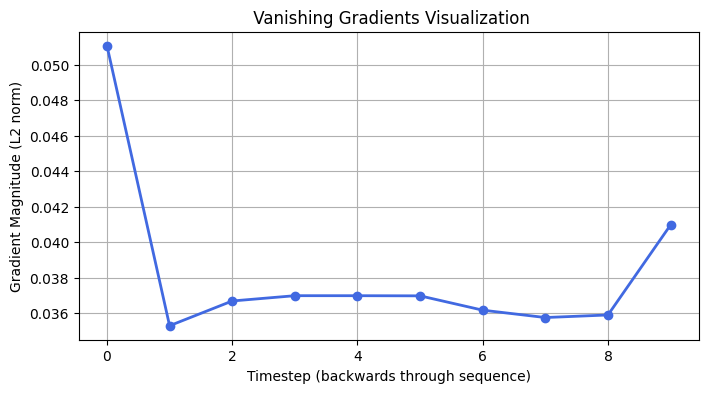

In [180]:
import matplotlib.pyplot as plt
if len(gradients_over_time) == 0:
    print(" No gradients recorded. Run backward_pass() first!")
else:
    print("\n GRADIENT MAGNITUDES (L2 norm):\n")
    for i, g in enumerate(gradients_over_time):
        print(f"Timestep {i:02d}: {g:.8f}")

    grads = np.array(gradients_over_time)
    plt.figure(figsize=(8,4))
    plt.plot(grads, marker='o', color='royalblue', linewidth=2)
    plt.xlabel("Timestep (backwards through sequence)")
    plt.ylabel("Gradient Magnitude (L2 norm)")
    plt.title(" Vanishing Gradients Visualization")
    plt.grid(True)
    plt.show()


The `backward_pass()` function performs **Backpropagation Through Time (BPTT)** to calculate how much each RNN weight contributed to the total loss. It starts from the last timestep and moves backward, computing the error at each step. The output error (`dy = p_t - y_true`) shows how wrong the prediction was, which is then used to find gradients for the output weights (`dWhy`, `dby`). This error is propagated back into the hidden layer (`dh`), adjusted using the tanh derivative (`dh_raw`), and then used to compute gradients for the input-to-hidden (`dWxh`), hidden-to-hidden (`dWhh`), and hidden bias (`dbh`) weights. The gradient from each timestep (`dh_next`) is passed backward in time to update earlier states. Finally, gradients are clipped to prevent explosion and returned to update all parameters during training.


Step 5: Training Loop (Manual Update)

This loop teaches the RNN to predict the next character by repeatedly passing the data forward (to get predictions) and backward (to compute and apply corrections).

    # Update weights manually
    for param, dparam in zip([Wxh, Whh, Why, bh, by],
                             [dWxh, dWhh, dWhy, dbh, dby]):
        param -= learning_rate * dparam

The loop updates all RNN weights using **gradient descent**.
`zip()` pairs each parameter (like `Wxh`, `Whh`, etc.) with its gradient (`dWxh`, `dWhh`, …).
Then this line —

```python
param -= learning_rate * dparam
```

applies the rule:
[
W = W - \eta \cdot \frac{\partial L}{\partial W}
]
It means each weight is slightly adjusted in the opposite direction of its gradient to reduce the loss.
In short — this is the step where **the RNN actually learns** by updating its parameters.


In [181]:
h_prev = np.zeros((hidden_size, 1)) #an empty memory at the start of the sequence
learning_rate = 1e-1 #defines how big a step you take when updating weights

for epoch in range(300): #Each epoch is one full “learning cycle.”
    loss, xs, hs, ps = forward_pass(X, Y, h_prev) #forward pass function
    dWxh, dWhh, dWhy, dbh, dby = backward_pass(xs, hs, ps, Y) #BPTT

    # Update weights manually
    for param, dparam in zip([Wxh, Whh, Why, bh, by],
                             [dWxh, dWhh, dWhy, dbh, dby]):
        param -= learning_rate * dparam

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")



 GRADIENT MAGNITUDE PER TIMESTEP (backwards):
Timestep 09 → Gradient magnitude: 0.05107070
Timestep 08 → Gradient magnitude: 0.03530460
Timestep 07 → Gradient magnitude: 0.03669757
Timestep 06 → Gradient magnitude: 0.03699566
Timestep 05 → Gradient magnitude: 0.03699471
Timestep 04 → Gradient magnitude: 0.03698681
Timestep 03 → Gradient magnitude: 0.03617993
Timestep 02 → Gradient magnitude: 0.03576571
Timestep 01 → Gradient magnitude: 0.03591001
Timestep 00 → Gradient magnitude: 0.04098123
 Finished backward pass.

Epoch 0, Loss: 20.7932

 GRADIENT MAGNITUDE PER TIMESTEP (backwards):
Timestep 09 → Gradient magnitude: 0.05202220
Timestep 08 → Gradient magnitude: 0.03488617
Timestep 07 → Gradient magnitude: 0.03729473
Timestep 06 → Gradient magnitude: 0.03588272
Timestep 05 → Gradient magnitude: 0.03763333
Timestep 04 → Gradient magnitude: 0.03830614
Timestep 03 → Gradient magnitude: 0.03517929
Timestep 02 → Gradient magnitude: 0.03535134
Timestep 01 → Gradient magnitude: 0.03544813
Ti

Step 6: Generate Text After Training

In [182]:
def sample(h, seed_idx, n):
    x = one_hot_encode(seed_idx, vocab_size)
    generated = []
    for t in range(n):
      #RNN recurrence formula
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        #This gives the raw scores (logits) for each possible next character.
        y = np.dot(Why, h) + by
        #Convert to probabilities
        p = np.exp(y) / np.sum(np.exp(y))
        #Randomly selects one character according to the predicted probabilities so sometimes it surprises you with variation!
        idx = np.random.choice(range(vocab_size), p=p.ravel())

        x = one_hot_encode(idx, vocab_size)
        generated.append(idx)
    return ''.join(idx_to_char[i] for i in generated)

print("Generated text:", sample(h_prev, char_to_idx['h'], 10))


Generated text: ello world


***VANILLA RNN - PyTorch Code***

Step 1: Setup character mappings (same as before)

In [183]:
import torch
import torch.nn as nn
import numpy as np

# Training text
text = "hello world"
chars = sorted(list(set(text)))
vocab_size = len(chars)

# Create char <-> index dictionaries
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}


Step 2: Define the RNN model in PyTorch

In [189]:
class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(vocab_size, hidden_size, nonlinearity='tanh', batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, h):
        out, h = self.rnn(x, h)
        out = self.fc(out)
        return out, h


Step 3: Prepare data tensors

In [190]:
# Encode text as integers
X = torch.tensor([char_to_idx[ch] for ch in text[:-1]], dtype=torch.long)
Y = torch.tensor([char_to_idx[ch] for ch in text[1:]], dtype=torch.long)

# One-hot encode input
X_onehot = torch.eye(vocab_size)[X].unsqueeze(0)  # shape (1, seq_len, vocab_size) since pytorch expects batch size too which is 1


Step 4: Train the RNN briefly

In [191]:
hidden_size = 16
rnn = VanillaRNN(vocab_size, hidden_size)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.05)

h = torch.zeros(1, 1, hidden_size)

for epoch in range(300):
  #Clears any leftover gradients from the previous iteration.
  #cPyTorch accumulates gradients by default, so we reset before each backward pass.
    optimizer.zero_grad()
    out, h = rnn(X_onehot, h.detach())
    loss = criterion(out.squeeze(0), Y)
    loss.backward()
    optimizer.step() #Update weights
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 2.0567
Epoch 50, Loss: 0.0004
Epoch 100, Loss: 0.0003
Epoch 150, Loss: 0.0002
Epoch 200, Loss: 0.0002
Epoch 250, Loss: 0.0001


Step 5: Generate new text (sampling loop)

In [192]:
def generate_text(model, start_char='h', length=20):
    model.eval() #Puts the model into inference mode, not training mode
    h = torch.zeros(1, 1, model.hidden_size)

    # Start input
    idx = char_to_idx[start_char]
    input_vec = torch.eye(vocab_size)[[idx]].unsqueeze(0)  # (1,1,vocab_size)

    output_text = start_char

    for _ in range(length):
        out, h = model(input_vec, h)
        probs = torch.softmax(out[0, -1], dim=0).detach().numpy()
        idx = np.random.choice(len(probs), p=probs)  # sample next char by probability
        char = idx_to_char[idx]
        output_text += char
        input_vec = torch.eye(vocab_size)[[idx]].unsqueeze(0)

    return output_text


In [195]:
print(generate_text(rnn, start_char='h', length=10))


hello world
